# Chicago Traffic Crash Data EDA
In this notebook, I'll be exploring Chicago traffic accident data from the [Chicago Data Portal](data.cityofchicago.org). Specifically, I'll be using these two datasets:
- [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)
- [Traffic Crashes - People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)

Here's a brief description of the first dataset, which I'll refer to from now on as the Crashes dataset:
> Crash data shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD). Data are shown as is from the electronic crash reporting system (E-Crash) at CPD, excluding any personally identifiable information.

And here's a description of the second dataset, which I'll call the People dataset:
> This data contains information about people involved in a crash and if any injuries were sustained. This dataset should be used in combination with the traffic Crash and Vehicle dataset. Each record corresponds to an occupant in a vehicle listed in the Crash dataset. Some people involved in a crash may not have been an occupant in a motor vehicle, but may have been a pedestrian, bicyclist, or using another non-motor vehicle mode of transportation.

We can join the two datasets using the CRASH_RECORD_ID field:
> Person data can be linked with the Crash and Vehicle dataset using the “CRASH_RECORD_ID” field.

For now, we'll set the People dataset aside and just explore the Crashes dataset.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import fiona
from shapely.geometry import shape, Point
import numpy as np
import platform

sns.set_style('dark')

In [2]:
home = Path('/Users/haydenroche/') if platform.system() == 'Darwin' else '/home/hayden/'
proj_root = Path(home, 'proj/ml/chicago_traffic_crashes/')
data_root = Path(proj_root, 'data/chicago')

crashes_csv = Path(data_root, 'Traffic_Crashes_-_Crashes.csv')
crashes_df = pd.read_csv(crashes_csv, dtype={'BEAT_OF_OCCURRENCE': 'float'}).set_index('CRASH_RECORD_ID')

Let's examine the columns of the crashes dataset first.

In [17]:
crashes_df.columns

Index(['RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I',
       'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE

I don't like typing in upper case, so let's make these all lower case.

In [34]:
crashes_df.columns = map(str.lower, crashes_df.columns)
crashes_df.columns

Index(['rd_no', 'crash_date_est_i', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type', 'lane_cnt',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'intersection_related_i', 'not_right_of_way_i',
       'hit_and_run_i', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence',
       'photos_taken_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude

Two columns I'm particularly intersted in are 'damage' and 'crash_type.' The Chicago Data Portal website describes these two columns:
> **CRASH_TYPE**: A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away.
>
> **DAMAGE**: A field observation of estimated damage.

Let's look at the values these two columns can take.

In [42]:
print(crashes_df['crash_type'].value_counts(), '\n')
# print(crashes_df['DAMAGE'].value_counts())

NO INJURY / DRIVE AWAY              306513
INJURY AND / OR TOW DUE TO CRASH     92300
Name: crash_type, dtype: int64 



I'd like to explore what features in the dataset correlate with crash severity (i.e. CRASH_TYPE) and high cost damage. We can encode the crash severity feature by representing non-severe crashes (CRASH_TYPE == NO INJURY / DRIVE AWAY) with a 0 and severe ones (INJURY AND / OR TOW DUE TO CRASH) with a 1. For damage, we can represent each category as an integer in the range \[1, 3\], where 1 is \\$500 or less and 3 is \\$1500 or more. First, let's see what features our intuition tells us would be helpful:
- **Location information**: Where in the city did the crash happen? [Chicago is divided into 77 community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago), which are further grouped into "sides" (e.g. the West Side). We could have a dummy variable for each of the 77 areas, but to keep the number of features from exploding, let's start by using the larger city sides, of which there are 9. To determine city side / community area, we'll use existing bounding boxes for the community areas from the Chicago Data Portal website and the coordinates of each crash.
- **Time information**: What time of day did the crash happen? What time of year? Was it a weekend? We'll represent time of day as a categorical variable taking the values early morning, morning, afternoon, and evening. We could use the hour of the day, but for the sake of simplicity and limiting the number of features, I prefer this approach. Similarly, with time of year, we'll create a "quarter" feature, which tells you what quarter of the year the crash happened in. The weekend variable will indicate if the crash happened on a weekend or not. I'll define the weekend as starting after 5:00 PM on Friday, when most people are getting off work, and ending Sunday just before midnight.
- **Weather condition**: Was it raining? Was it snowing? Was there fog/haze hurting visibility? I'll use dummy coding to indicate if it was rainy, snowy, or foggy/hazey.
- **Collision type**: Did the crash involve the driver hitting a parked car? Did they rear end someone? Did they hit a pedestrian?
- **Lane count**: How many lanes was the road where the crash happened?
- **Intersection information**: Was the crash related to an intersection?
- **Right of way information**: Did the crash occur because someone violated the right-of-way?
- **Hit and run**: Was the crash a hit and run?
- **Work zone information**: Did the crash take place in a work zone? Were there workers present?
- **Vehicle information**: How many people were in the vehicle? What type of car was it?
- **Driver information**: Was the driver under the influence of alcohol? Were they using a cell phone? How old were they? Were they from out of state?
- **Speeding**: Was the driver speeding?
- **Number of vehicles involved**: How many vehicles were involved in the crash?

Before we start examining and crafting these features, let's drop the columns we won't need.

In [39]:
columns_to_drop = ['rd_no',
                   'crash_date_est_i',
                   'posted_speed_limit',
                   'traffic_control_device',
                   'device_condition',
                   'lighting_condition',
                   'alignment',
                   'report_type',
                   'date_police_notified',
                   'beat_of_occurrence',
                   'photos_taken_i',
                   'statements_taken_i',
                   'dooring_i',
                   'location']
crashes_df.drop(columns=columns_to_drop, inplace=True)

In [41]:
print(crashes_df[crashes_df['first_crash_type'] == 'PEDESTRIAN']['crash_type'].value_counts())

INJURY AND / OR TOW DUE TO CRASH    8187
NO INJURY / DRIVE AWAY              1323
Name: crash_type, dtype: int64


## Cleaning Null Values
Let's check out the null counts for each column.

In [10]:
crashes_df.isnull().sum()

rd_no                              1782
crash_date_est_i                 369299
crash_date                            0
posted_speed_limit                    0
traffic_control_device                0
device_condition                      0
weather_condition                     0
lighting_condition                    0
first_crash_type                      0
trafficway_type                       0
lane_cnt                         200262
alignment                             0
roadway_surface_cond                  0
road_defect                           0
report_type                        9411
crash_type                            0
intersection_related_i           310116
not_right_of_way_i               380281
hit_and_run_i                    287658
damage                                0
date_police_notified                  0
prim_contributory_cause               0
sec_contributory_cause                0
street_no                             0
street_direction                      2


Let's clean up some of these. Several of the injuries-related columns should be easy. For those columns reporting numbers of injuries, it seems reasonable to replace all nulls with zeros.

In [11]:
injury_cols = [
    'injuries_total',
    'injuries_fatal',
    'injuries_incapacitating',
    'injuries_non_incapacitating',
    'injuries_reported_not_evident',
    'injuries_unknown'
]
crashes_df[injury_cols] = crashes_df[injury_cols].fillna(0)
crashes_df[injury_cols].isnull().sum()

injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_unknown                 0
dtype: int64

Let's see the number of crashes grouped by month.

In [12]:
crashes_df['crash_date'].head()

CRASH_RECORD_ID
00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e7985d1aa4e5e8a4cda9a52a7627c1210281d8c7eefe757fe45e1585eaf80c0463cc9ed454bdd2ae20b2c    03/27/2019 04:20:00 PM
0002fb938eb0feaea33820fa55b71e4ea0b332125e15101c67a2e73971042abdd7daa58a4a14c43195d02902ca8cbdd1d3798055b4e129e194bfd26c77abb0d9    03/06/2018 03:00:00 PM
0003fc68d857da032b1beafa8f7893ce0b123ce6b2dee54c029bbd3b12902247b091033f7b6f62ed66ee97224e6dc5aed3eef2d007923a8d5000c63743005802    10/25/2016 02:10:00 PM
00060f93d2ae8d4e4c7fe75ac17055dd69a081d0b928a52655ccf9f719dab5e0ab62392ffe92aeed79bf3e1be2239745efad0e944f85eefb48f53c1cf41e19b2    01/21/2020 04:16:00 PM
0006882952e53c291df267014a03b57684383e9ad66d9e5723ff9cb22e76cbfbc7b6cd1ff0a3ceab28fc67638b47132e8d434cf510bc7bded7bfb98c95f569b5    10/04/2019 12:00:00 PM
Name: crash_date, dtype: object

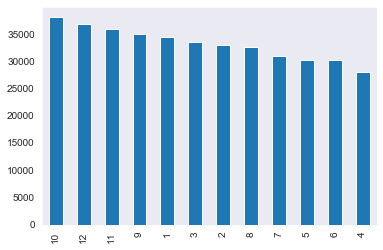

In [13]:
crashes_df['crash_month'].value_counts().plot(kind='bar')

Interestingly, the spring and summer months have fewer crashes than the fall and winter months. Just speculating, that could be because of poor weather conditions during the colder months. It could also be because of reckless/drunk driving around the holidays. Let's see the top 10 days of the year with the most crashes.

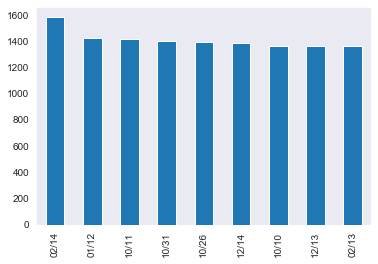

In [14]:
crashes_df['crash_day_of_year'] = crashes_df['crash_date'].str[0:5]
crashes_df['crash_day_of_year'].value_counts()[0:9].plot(kind='bar')

- 02/14 = Valentine's Day
- 01/12 = ???
- 10/11 = ???
- 10/31 = Halloween
- 10/26 = The weekend before Halloween?
- 12/14 = Christmas parties?
- 02/13 = Washington's Birthday can fall on 2/15, so 2/13 would be the Saturday before that.
- 12/13 = Christmas parties?
- 11/15 = Thanksgiving-related?

In [129]:
class AreaFinder:
    def __init__(self, shapefile):
        self.areas = [(area['properties']['community'], area['geometry']) for _, area in fiona.open(shapefile).items()]
    
    def find(self, longitude, latitude):
        p = Point(longitude, latitude)
        
        for area in self.areas:
            if p.within(shape(area[1])):
                return area[0]
        
        return None

area_finder = AreaFinder(Path(data_root, 'shapefiles/community_areas/geo_export_f824396e-e8f4-447d-bf98-292055225a02.shp'))

crashes_df['community_area'] = crashes_df.apply(lambda rec: area_finder.find(rec['longitude'], rec['latitude']), axis=1)

In [ ]:
I'd like to plot the accident locations on a map of the city. For the time being, we'll filter out records where the latitude and longitude are null, or where they're both 0.

In [15]:
crashes_df = crashes_df.loc[crashes_df['latitude'].notnull()
                          & crashes_df['longitude'].notnull()
                          & (crashes_df['latitude'] != 0)
                          & (crashes_df['longitude'] != 0)]

We'll use [GeoPandas](https://geopandas.org/index.html) to help with plotting:
> GeoPandas is an open source project to make working with geospatial data in python easier. 

We'll load a [shapefile](https://en.wikipedia.org/wiki/Shapefile) of the city and then use our dataframe's longitude and latitude measurements to plot the sites of the crashes. You can get the shapefile I'm using [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw).

In [ ]:
import folium

m = folium.Map(
    location=[41.881944, -87.627778]
#     tiles='Chicago'
)

# crashes_df.apply(lambda rec: print(rec['latitude']), axis=1)

crashes_df.apply(lambda rec: folium.Marker([rec['latitude'], rec['longitude']], popup=rec['community_area']).add_to(m), axis=1)

# for lat, long in crashes_df[['latitude, longitude']]:
#     print(lat)
# folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>',

m



In [137]:
fig, ax = plt.subplots(figsize=(100, 100))

city_map = gpd.read_file(Path(data_root, 'shapefiles/community_areas/geo_export_f824396e-e8f4-447d-bf98-292055225a02.shp'))
city_map.plot(ax=ax, alpha=0.6)

areas = crashes_df.groupby('community_area')

for name, area in areas:
    ax.plot(area.longitude, area.latitude, markersize=0.000001, label=name)
    
# ax.legend()

% of crashes with > 0 injuries: 12.12.


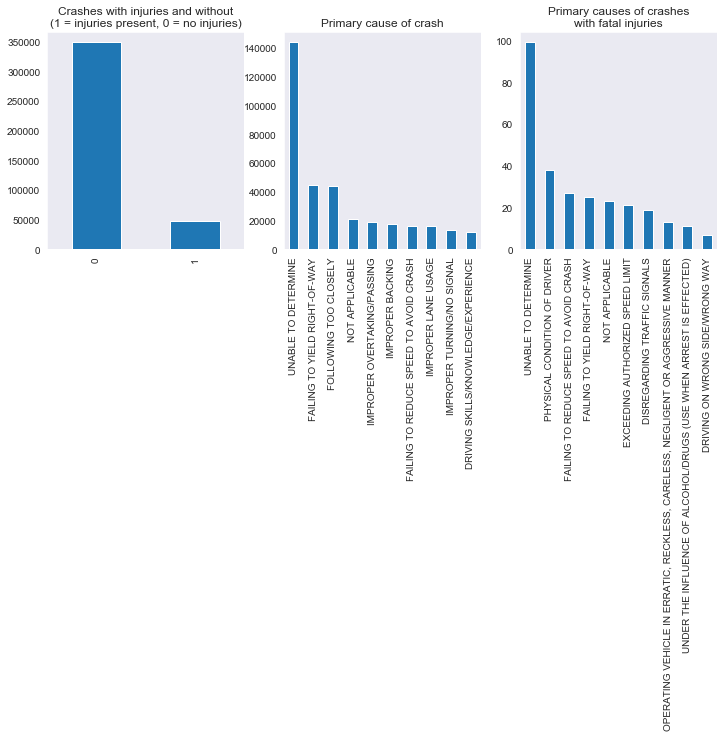

In [84]:
# What percentage of crashes had at least 1 injury?
injuries_present_vs_not = crashes_df['injuries_total'].apply(lambda x: np.where(x > 0, 1, 0)).value_counts()
print('% of crashes with > 0 injuries: {:.2f}.'.format(100 * injuries_present_vs_not[1] / injuries_present_vs_not.sum()))

# What are the top primary causes of crashes?
top_primary_causes = crashes_df['prim_contributory_cause'].value_counts()[0:10]

# What are the biggest causes of fatal injuries?
top_primary_causes_fatal = crashes_df.loc[crashes_df['injuries_fatal'] > 0, ['prim_contributory_cause']]['prim_contributory_cause'].value_counts()[0:10]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
injuries_present_vs_not.plot(ax=axs[0], kind='bar', title='Crashes with injuries and without\n(1 = injuries present, 0 = no injuries)')
top_primary_causes.plot(ax=axs[1], kind='bar', title='Primary cause of crash')
top_primary_causes_fatal.plot(ax=axs[2], kind='bar', title='Primary causes of crashes\nwith fatal injuries')

https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab

So a little more than 1 in 10 crashes resulted in at least 1 injury.

What % of crashes were caused primarily or secondarily by phone usage?

In [64]:
phone_causes = ['TEXTING', 'CELL PHONE USE OTHER THAN TEXTING']
print('% of crashes with phone usage as a cause: {:.2f}.' .format(100 * (len(crashes_df[crashes_df['prim_contributory_cause'].isin(phone_causes)])
                                                                + len(crashes_df[crashes_df['sec_contributory_cause'].isin(phone_causes)]))
                                                                / len(crashes_df)))

% of crashes with phone usage as a cause: 0.29.


Only 0.29% of crashes are caused by phone usage.

## Questions
- When are there the most drinking related crashes?
- Of the days with the most crashes, what percentage are drinking related?
- Cell phone usage?
- What types of crashes lead to the most injuries? What about fatal injuries? (see first_crash_type)
- For the more dangerous crash types, what are the typical causes? (see prim_contributory_cause)
- Correlations with regions of the city? Would be nice to add a community area column. There's got to be a map API we can use for this. Check here: https://www.google.com/maps/d/u/0/viewer?ll=41.81602647502002%2C-87.63810850260546&spn=0.340714%2C0.699692&msa=0&mid=1O-3Uot4mSetKW-M_govahruUjDc&z=10.
- Most dangerous streets/intersections?
- Most expensive types of crashes? (see damage -- maybe we can do regression to predict the cost bucket of crashes)
- Region where hit and runs happen the most?
- Correlation between accident severity and hit and run?
- num_units higher in highway collisions?

In [51]:
crashes_df['sec_contributory_cause'].unique()

array(['NOT APPLICABLE', 'UNABLE TO DETERMINE',
       'IMPROPER TURNING/NO SIGNAL',
       'FAILING TO REDUCE SPEED TO AVOID CRASH', 'DISREGARDING STOP SIGN',
       'FOLLOWING TOO CLOSELY', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'EQUIPMENT - VEHICLE CONDITION', 'DISREGARDING TRAFFIC SIGNALS',
       'IMPROPER BACKING', 'DISREGARDING ROAD MARKINGS',
       'FAILING TO YIELD RIGHT-OF-WAY', 'IMPROPER LANE USAGE',
       'IMPROPER OVERTAKING/PASSING',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'WEATHER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'DRIVING ON WRONG SIDE/WRONG WAY', 'DISREGARDING YIELD SIGN',
       'EXCEEDING SAFE SPEED FOR CONDITIONS',
       'DISREGARDING OTHER TRAFFIC SIGNS',
       'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
       'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
  

# OLD STUFF DOWN HERE vvv

As of the writing of this post, the People dataset contains 867K records, and the Crash dataset contains 399K records. To keep memory usage reasonable, we'll be using Dask DataFrames. From the Dask [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html), Common Uses section:
> Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed.

If you've got a lot of RAM, you might be able to load these datasets in memory, but on my laptop, that's not feasible.

One thing I'd like to do is plot all the crash sites on a map of the city. However, we are missing latitude and longitude data for 2183 records. On the other hand, we're only missing the street name for a single record. We should be able to use the street names and numbers to fill in the missing latitude and longitude values. First, let's check if that one record missing a street name has latitude and longitude data.

In [17]:
crashes_df.loc[crashes_df['street_name'].isna(), ['street_no', 'latitude', 'longitude', 'location']]

Empty DataFrame
Columns: [street_no, latitude, longitude, location]
Index: []

This record has no location information aside from the street number. Let's drop this record by only keeping records with non-null street names in the dataframe.

In [18]:
crashes_df = crashes_df.loc[crashes_df['street_name'].notnull()]

Let's verify that there are no records with a null street name, now.

In [14]:
crashes_df.loc[:, 'street_name'].isnull().sum()

0

Good. Now, we need to fill in the latitude and longitude values for the records that don't have them. Googling around, it seems like the geopy package will do what we want:
> geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

geopy is backed by a geolocation service of your choosing, such as Google Maps. We'll use [Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim):
> Nominatim (from the Latin, 'by name') is a tool to search OSM data by name and address (geocoding) and to generate synthetic addresses of OSM points (reverse geocoding).

OSM is [OpenStreetMap](https://www.openstreetmap.org):
> OpenStreetMap is a map of the world, created by people like you and free to use under an open license.

Here's an example of how to use the package:

In [15]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='chicago_traffic_crashes')
location = geolocator.geocode('175 5th Avenue NYC')
print((location.latitude, location.longitude))

(40.741059199999995, -73.98964162240998)


So, we should be able to write a class that holds the geolocator object and has a function which takes the street number, street name, and city, and returns us the coordinates of that address. Note that I've added a 1 second sleep in the get_coordinates method. If we try to get_coordinates as fast as we can loop, [Nominatim will cut us off](https://operations.osmfoundation.org/policies/nominatim/).

In [16]:
import time

class AddrToCoordsConverter():
    def __init__(self, app_name):
        self.geolocator = Nominatim(user_agent=app_name)

    def get_coordinates(self, street_number, street_name, city):
        location = self.geolocator.geocode('{} {} {}'.format(street_number, street_name, city))
        time.sleep(1)
        if location:
            return (location.latitude, location.longitude)
        else:
            return None

Let's try it out with that example address.

In [17]:
addr_2_coords_conv = AddrToCoordsConverter('chicago_traffic_crashes')
addr_2_coords_conv.get_coordinates(175, '5th Avenue', 'NYC')

(40.741059199999995, -73.98964162240998)

We need to get all rows where the latitude and longitude are both null. We started with 2183 rows like this, then we dropped 1, so there should be 2182 left. Let's check.

In [18]:
len(crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()])

2182

Let's get an idea of what streets are problematic in terms of getting their latitude and longitude.

In [19]:
# crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()]['street_name'][0:10].value_counts().plot(kind='bar')

Let's iterate through the rows where the latitude and longitude are null and attempt to fill in those values using our converter class. This will take awhile, due to the half second sleep between requests to Nominatim. I'm gonna go have some coffee...

In [20]:
# null_location_idxs = crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()].index
# print('# nulls: {}.'.format(len(null_location_idxs)))

# for idx in null_location_idxs:
#     street_no, street_name = crashes_df.loc[idx, ['street_no', 'street_name']]
#     print('{} {}'.format(street_no, street_name))
#     lat_and_long = addr_2_coords_conv.get_coordinates(street_no, street_name, 'Chicago')
    
#     if lat_and_long:
#         crashes_df.loc[idx, ['latitude', 'longitude']] = lat_and_long
#     else:
#         print('No coordinates found.')

Good.